In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg as LA
from sklearn.preprocessing import StandardScaler
import random

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras import losses
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Preprocessing**

In [3]:
# vidcap = cv2.VideoCapture('/content/drive/MyDrive/3CYL_Flow.mp4')
vidcap = cv2.VideoCapture('/content/drive/MyDrive/Fluid Mechanics/3CYL_Flow.mp4')
target_fps = 5
fps = vidcap.get(cv2.CAP_PROP_FPS)
print(fps)
frame_count = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))

skip_interval = int(round(fps / target_fps)) - 1
success, image = vidcap.read()

count = 0
rows = 0
columns = 0
image_size = 0
flag = 0
frames = 0

while success:
    success, image = vidcap.read()
    if count % skip_interval == 0 and success:
        # cv2.imwrite(f"/content/frames{num}.jpg", image)
        cv2.imwrite(f"/content/drive/MyDrive/Fluid Mechanics\Frame{frames}.jpg", image)
        frames +=1
        if flag == 0:
            rows = image.shape[0]
            columns = image.shape[1]
            image_size = rows * columns
            flag = 1

    if count >= frame_count or not success:
        break

    count += 1

vidcap.release()
# frames = num

# '/content/drive/MyDrive/3CYL_Flow.mp4'
# 'Fluid Mechanics\CYL_Flow.mp4'

24.0


In [4]:
def save_image(data, colour, file_name):

    sizes = np.shape(data)
    height = float(sizes[0])
    width = float(sizes[1])

    fig = plt.figure()
    fig.set_size_inches(width/height, 1, forward=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)

    ax.imshow(data, cmap=colour)
    plt.savefig(file_name, dpi = height)
    plt.close()

In [5]:
def GaussianNoise(img, perc_noise):
    mean = 0
    var = perc_noise
    sigma = var ** 0.5
    gaussian = np.random.normal(mean, perc_noise, (rows, columns)) #  np.zeros((224, 224), np.float32)

    noisy_image = np.zeros(img.shape, np.float32)

    if len(img.shape) == 2:
        noisy_image = img + gaussian
    else:
        noisy_image[:, :, 0] = img[:, :, 0] + gaussian
        noisy_image[:, :, 1] = img[:, :, 1] + gaussian
        noisy_image[:, :, 2] = img[:, :, 2] + gaussian

    cv2.normalize(noisy_image, noisy_image, 0, 255, cv2.NORM_MINMAX, dtype=-1)
    noisy_image = noisy_image.astype(np.uint8)
    return noisy_image, gaussian

In [6]:
def SaltPepperNoise(img, percent_noise):
    noisy = img
    number_of_pixels = int(percent_noise*image_size/200)
    for i in range(number_of_pixels):
        y_coord=random.randint(0, rows - 1)
        x_coord=random.randint(0, columns - 1)
        noisy[y_coord][x_coord] = 255

    # number_of_pixels = random.randint(300 , 10000)
    for i in range(number_of_pixels):
        y_coord=random.randint(0, rows - 1)
        x_coord=random.randint(0, columns - 1)
        noisy[y_coord][x_coord] = 0

    return noisy

In [7]:
def load_video_data(rows, columns, image_size, frames, Noise = None, percent_noise = 0, plt1 = False):
  # rows = 708
  # columns = 1558
  # image_size = rows * columns
  # frames = 30

  # string = f"/content/frames0.jpg"
  string = f"/content/drive/MyDrive/Fluid Mechanics\Frame0.jpg"
  image = cv2.imread(string)
  if Noise == 'Gaussian':
      noisy, gauss = GaussianNoise(image, percent_noise)
      # noisy = cv2.cvtColor(noisy, cv2.COLOR_BGR2RGB)
      image = np.round(noisy).astype('uint8')
  if Noise == 'SaltPepper':
      noisy = SaltPepperNoise(image, percent_noise)
      image = noisy
  if plt1 == True:
      plt.imshow(image)
  data = image.reshape(image_size, 1, 3)

  for i in range(1, frames):
    if i < 10:
      # string = f"/content/frames{i}.jpg"
      string = f"/content/drive/MyDrive/Fluid Mechanics\Frame{i}.jpg"
    else:
      # string = f"/content/frames{i}.jpg"
      string = f"/content/drive/MyDrive/Fluid Mechanics\Frame{i}.jpg"

    image = cv2.imread(string)
    # print(type(image))
    if Noise == 'Gaussian':
      noisy, gauss = GaussianNoise(image, percent_noise)
      # noisy = cv2.cvtColor(noisy, cv2.COLOR_BGR2RGB)
      image = np.round(noisy).astype('uint8')
    if Noise == 'SaltPepper':
      noisy = SaltPepperNoise(image, percent_noise)
      image = noisy
    frame_data = image.reshape(image_size, 1, 3)
    data = np.concatenate((data, frame_data), axis=1)
    # print(i)

  return data

def HSV_Processing(data):
  print(data.shape)
  hsv = cv2.cvtColor(data, cv2.COLOR_BGR2HSV)
  hsv = 2*hsv[:,:,0]
  return hsv

dataset_original = load_video_data(rows, columns, image_size, frames)
dataset = HSV_Processing(dataset_original)

(1103064, 188, 3)


In [8]:
print(dataset.shape)

(1103064, 188)


**Scaling**

In [9]:
scaler = StandardScaler()
def Scaling(data):
  scaler.fit(data)
  A = scaler.transform(data)
  return A

A = Scaling(dataset)
print(dataset)
print(A)

[[68 68 68 ... 68 70 70]
 [68 68 68 ... 68 70 70]
 [68 68 68 ... 68 70 70]
 ...
 [78 78 78 ... 92 90 90]
 [78 78 78 ... 94 90 90]
 [78 78 78 ... 94 90 90]]
[[1.42399524 0.98585026 0.74270794 ... 0.57210153 0.78557177 0.76741959]
 [1.42399524 0.98585026 0.74270794 ... 0.57210153 0.78557177 0.76741959]
 [1.42399524 0.98585026 0.74270794 ... 0.57210153 0.78557177 0.76741959]
 ...
 [3.25071492 2.28601092 1.74809557 ... 2.77537269 2.68154614 2.6184473 ]
 [3.25071492 2.28601092 1.74809557 ... 2.95897862 2.68154614 2.6184473 ]
 [3.25071492 2.28601092 1.74809557 ... 2.95897862 2.68154614 2.6184473 ]]


**Singular Value Decomposition**

In [10]:
def SVD(A, frames):
  A_T = np.transpose(A)
  A_2 = np.matmul(A_T, A)
  eigenvalues, V = LA.eig(A_2)
  E = np.zeros((frames,frames))
  for i in range(frames):
    E[i][i] = np.sqrt(eigenvalues[i])
  print(eigenvalues.shape)

  V_T = np.transpose(V)
  V_T_inv = LA.inv(V_T)
  E_inv = LA.inv(E)
  U1 = np.dot(A,V_T_inv)
  print(U1.shape)
  U = np.dot(U1, E_inv)
  return U, E, V_T, eigenvalues

U, E, V_T, eigenvalues = SVD(A, frames)
sorted_eigens = np.argsort(eigenvalues)[::-1]
# print(sorted_eigens)

(188,)
(1103064, 188)


Number of components to retain 90.0% variance: 57


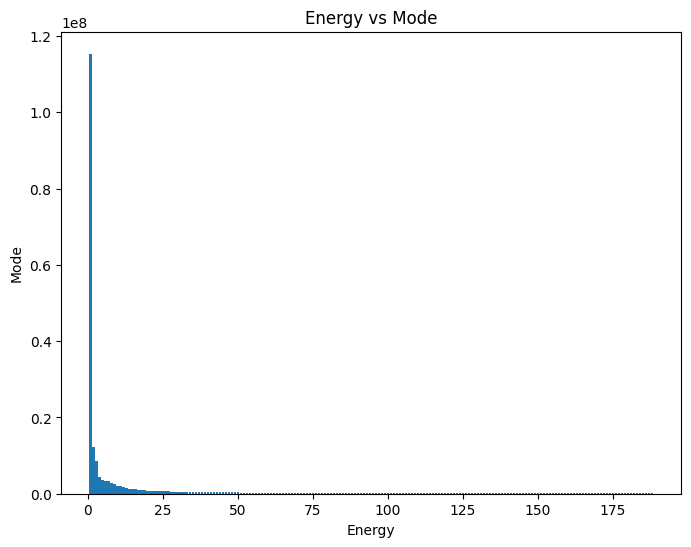

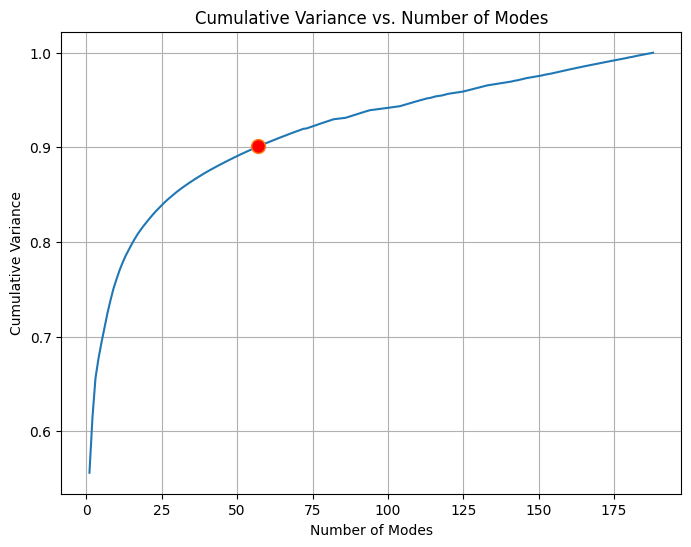

In [11]:
def Required_Modes(required_variance, eigenvalues, EvsM = False, VarvsM = False, Plots = False):
  components = np.arange(1, frames+1, 1, dtype=int)
  cumulative_variance = np.zeros(len(eigenvalues))
  total = np.sum(eigenvalues)
  for i in range(len(eigenvalues)):
    j=0
    while j!=i+1:
      cumulative_variance[i] += eigenvalues[j]/total
      j+=1
  if EvsM:
    plt.figure(figsize=(8, 6))
    plt.bar(components, eigenvalues)
    plt.title('Energy vs Mode')
    plt.xlabel('Energy')
    plt.ylabel('Mode')

  if VarvsM:
    plt.figure(figsize=(8, 6))
    plt.plot(components, cumulative_variance)
    plt.xlabel('Number of Modes')
    plt.ylabel('Cumulative Variance')
    plt.title('Cumulative Variance vs. Number of Modes')
    plt.grid(True)

  n=0
  # required_variance = 0.90
  for i in range(len(cumulative_variance)):
    if cumulative_variance[i] - required_variance > 0:
      n = n + i
      break

  if VarvsM:
    plt.plot(n+1, cumulative_variance[n], marker="o", markersize=10, markerfacecolor="red")
    print(f"Number of components to retain {required_variance * 100}% variance: {n+1}", end = "\n")

  if Plots == False:
    return n
  else:
    return n, components, eigenvalues, cumulative_variance

n = Required_Modes(0.9, eigenvalues, True, True)

**Dimensional Reduction**

In [12]:
def Dim_Reduction(U,E,V_T,n):
  U_Reduced = U[:, 0:n]
  E_Reduced = E[0:n, 0:n]
  V_T_Reduced = V_T[0:n, :]
  A_Reduced1 = np.dot(U_Reduced,E_Reduced)
  A_Reduced = np.dot(A_Reduced1, V_T_Reduced)

  data_Reduced = scaler.inverse_transform(A_Reduced)
  data_Reduced = np.round(data_Reduced).astype('uint8')
  return data_Reduced

data_Reduced = Dim_Reduction(U,E,V_T,n)

**Converting to 3D HSV Image**

In [ ]:
def Image_Reconstruction(image_size, frames, data_Reduced):
  Saturation = np.full((image_size, frames), 254).astype(np.uint8)
  HSV_value = np.full((image_size, frames), 254).astype(np.uint8)
  data_Reduced = np.divide(data_Reduced,2)
  Images_Reduced = np.stack((data_Reduced,Saturation,HSV_value),axis=2)
  Images_Reduced = Images_Reduced.astype(np.uint8)
  return Images_Reduced

Images_Reduced = Image_Reconstruction(image_size, frames, data_Reduced)

**Plotting**

In [ ]:
index = 18
Recreated_HSV = Images_Reduced[:, index, :].reshape((rows,columns,3))

Recreated_RGB = cv2.cvtColor(Recreated_HSV, cv2.COLOR_HSV2RGB)
img_BGR = cv2.imread(f"Fluid Mechanics\Frame{index}.jpg")
img_RGB = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(17, 10))
plt.subplot(2,2,1)
plt.imshow(img_RGB)
plt.title(f"Original Frame {index+1}")
plt.subplot(2,2,2)
plt.imshow(Recreated_RGB)
plt.title(f"Recreated Frame {index+1}")

In [ ]:
plt.title(f"Mode No. 0")
plt.imshow(U[:, 0].reshape((rows,columns)) , cmap='seismic', aspect='auto')

In [ ]:
def Plot_10_Modes(U, rows, columns, cm):
  plt.figure(figsize=(15, 20))
  for i in range(1,11):
    U_single = U[:, i].reshape((rows,columns))
    plt.subplot(5,2,i)
    plt.imshow(U_single, cmap=cm, aspect='auto')
    plt.title(f"Mode No. {i}")

Plot_10_Modes(U, rows, columns, 'seismic')
# save_image(U_8, 'winter', 'plot1.png')

In [ ]:
print(V_T.shape)
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.bar(range(188), V_T[1,:])
plt.title("Variation of Mode 2 with time")
plt.xlabel("Time")
plt.ylabel("V Coefficient")
plt.subplot(1,2,2)
plt.bar(range(188), V_T[4,:])
plt.title("Variation of Mode 5 with time")
plt.xlabel("Time")
plt.ylabel("V Coefficient")

# **Noise**

In [ ]:
img_path = f"Fluid Mechanics\Frame{index}.jpg"

img_test = cv2.imread(img_path)
img_test = cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB)
percent_noise = 80

plt.figure(figsize=(17, 10))
plt.subplot(2,2,1)
plt.imshow(img_test)
plt.title(f"Original Image {index+1}")

noisy_image = img_test
noisy_image, gaussian = GaussianNoise(img_test, percent_noise)
# noisy_image = SaltPepperNoise(noisy_image, percent_noise)

plt.subplot(2,2,2)
plt.imshow(gaussian)
plt.title(f"Gaussian {index+1}")
plt.subplot(2,1,2)
plt.imshow(noisy_image)
plt.title(f"Noisy Image {index+1}")

In [ ]:
# def Optimal_Hard_Threshold(sigma, image_size, eigenvalues):
#   Threshold = int(np.floor(2.309*sigma*np.sqrt(image_size)))
#   n = (eigenvalues > Threshold).sum()
#   return n

noisy_data = load_video_data(rows, columns, image_size, frames, 'SaltPepper', percent_noise)
# noisy_data = load_video_data(rows, columns, image_size, frames, 'Gaussian', percent_noise)

In [ ]:
print(noisy_data.shape)
print(dataset_original.shape)

In [ ]:

noisy_hsv = HSV_Processing(noisy_data)
nA = Scaling(noisy_hsv)
nU, nE, nV_T, n_eigenvalues = SVD(nA, frames)
nN = Required_Modes(0.1, n_eigenvalues, True, True)
# nN = Optimal_Hard_Threshold(percent_noise, image_size, n_eigenvalues)
nReduced = Dim_Reduction(nU,nE,nV_T,nN)
noisy_Reduced = Image_Reconstruction(image_size, frames, nReduced)

noisy_HSV = noisy_Reduced[:, index, :].reshape((rows,columns,3))

noisy_RGB = cv2.cvtColor(noisy_HSV, cv2.COLOR_HSV2RGB)
img_BGR = cv2.imread(f'Fluid Mechanics\Frame{index}.jpg')
img_RGB = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2RGB)

Recreated_HSV = Images_Reduced[:, index, :].reshape((rows,columns,3))
Recreated_RGB = cv2.cvtColor(Recreated_HSV, cv2.COLOR_HSV2RGB)

noi = noisy_data[:, index, :].reshape((rows,columns,3))
noi = cv2.cvtColor(noi, cv2.COLOR_BGR2RGB)

In [ ]:
plt.figure(figsize=(17, 10))
plt.subplot(1,3,1)
plt.imshow(img_RGB)
plt.title(f"Original Image {index+1}")
plt.subplot(1,3,2)
plt.imshow(noi)
plt.title(f"Noisy Image {index+1}")
plt.subplot(1,3,3)
plt.imshow(noisy_RGB)
plt.title(f"Denoised Image {index+1}")

In [ ]:
plt.imshow(nU[:, 0].reshape((rows,columns)), cmap='seismic', aspect='auto')

In [ ]:
def Plot_10_Modes(nU, rows, colnumns, cm):
  plt.figure(figsize=(15, 20))
  for i in range(1,11):
    U_single = nU[:, i].reshape((rows,columns))
    plt.subplot(5,2,i)
    plt.imshow(U_single, cmap=cm, aspect='auto')
    plt.title(f"Mode No. {i}")

Plot_10_Modes(nU, rows, columns, 'seismic')

# **ML Model**

In [ ]:
def resize(img, new_width):
    height, width = img.shape[0:2]
    ratio = height/width
    new_height = int(ratio*new_width)
    resized_image = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_LINEAR)
    return resized_image

In [ ]:
def rectangle_to_square(image):
   height, width, channels = image.shape

  # Calculate padding amount
   padding_top = int((width - height) / 2)
   padding_bottom = width - height - padding_top

  # Add padding using constant value (0 for black)
   padded_image = cv2.copyMakeBorder(image, padding_top, padding_bottom, 0, 0, cv2.BORDER_CONSTANT, value=(0, 0, 0))

   return padded_image

In [ ]:
# def ConvertToStacked(data, new_width):
#     # stacked_data = np.empty((frames, new_width, new_width, 3))
#     img = data[:,0,:].reshape(rows,columns,3)
#     img = rectangle_to_square(img)
#     img = resize(img, new_width)
#     # print(img.shape)
#     img = np.round(img).astype('uint8')
#     stacked_data = img
#     # stacked_data = np.concatenate([stacked_data, img], axis=0)

#     for i in range(1, frames):
#         img = data[:,i,:].reshape(rows,columns,3)
#         img = rectangle_to_square(img)
#         img = resize(img, new_width)
#         # print(img.shape)
#         # if i == 8:
#             # plt.imshow(img)
#         img = np.round(img).astype('uint8')
#         # if i == 8:
#             # plt.imshow(img)
#         # stacked_data[i,:,:,:] = img
#         stacked_data = np.stack([stacked_data, img])

#     return stacked_data

def ConvertToStacked(data, new_width):
  processed_images = []  # List to store processed images

  for i in range(frames):
    img = data[:, i, :].reshape(rows, columns, 3)
    # img = rectangle_to_square(img)
    img = resize(img, new_width)
    img = np.round(img).astype('uint8')
    processed_images.append(img)

  stacked_data = np.stack(processed_images)  # Stack processed images into final array

  return stacked_data

new_width = 779
stacked_data_original = ConvertToStacked(dataset_original, new_width)
stacked_data_noisy = ConvertToStacked(noisy_data, new_width)
print(stacked_data_noisy.shape)
print(stacked_data_original.shape)

In [ ]:
stacked_data_noisy = np.delete(stacked_data_noisy, [0, stacked_data_noisy.shape[1]-1], 1)
stacked_data_noisy = np.delete(stacked_data_noisy, [0, 1, stacked_data_noisy.shape[2]-1], 2)
stacked_data_original = np.delete(stacked_data_original, [0, stacked_data_original.shape[1]-1], 1)
stacked_data_original = np.delete(stacked_data_original, [0, 1, stacked_data_original.shape[1]-1], 2)
# print(stacked_data_noisy.shape)

In [ ]:
f, h, w, ch = stacked_data_original.shape
imig = stacked_data_noisy[18].reshape(h, w, 3)
imig = cv2.cvtColor(imig, cv2.COLOR_BGR2RGB)
plt.imshow(imig, cmap="binary")
print(dataset_original.shape)

In [ ]:
stacked_data_original = stacked_data_original.astype('float32') / 255.
stacked_data_noisy = stacked_data_noisy.astype('float32') / 255.

x_train_noisy, x_test_noisy, x_train, x_test = train_test_split(stacked_data_noisy, stacked_data_original)

f, h, w, ch = stacked_data_original.shape

In [ ]:

# print(h)
# print(w)
# print(f)

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(h, w, ch)))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))


model.add(MaxPooling2D((2, 2), padding='same'))

model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(3, (3, 3), activation='relu', padding='same'))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

model.summary()

In [ ]:
# f, h, w, ch = stacked_data_original.shape
# imig = x_train_noisy[0].reshape(h, w, 3)
# imig = cv2.cvtColor(imig, cv2.COLOR_BGR2RGB)
# plt.imshow(imig, cmap="binary")

In [ ]:
model.fit(x_train_noisy, x_train, epochs=20, batch_size=1, shuffle=True,
          validation_data=(x_test_noisy, x_test))

model.evaluate(x_test_noisy, x_test)
no_noise_img = model.predict(x_test_noisy)

In [ ]:
print(x_test.shape)

In [ ]:
from math import log10, sqrt
def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr

AvgPSNR_noisy = 0
AvgPSNR_denoised = 0

for i in range(x_test.shape[0]):
    AvgPSNR_noisy += PSNR(x_test[i].reshape(h, w, 3), x_test_noisy[i].reshape(h, w, 3))
    AvgPSNR_denoised += PSNR(x_test[i].reshape(h, w, 3), no_noise_img[i].reshape(h, w, 3))
AvgPSNR_noisy = AvgPSNR_noisy/f
AvgPSNR_denoised = AvgPSNR_denoised/f
print(AvgPSNR_noisy)
print(AvgPSNR_denoised)

In [ ]:
plt.figure(figsize=(8, 24))
# plt.suptitle("Recreating Frames using AutoEncoder")
for i in range(3, 13, 2):
    plt.subplot(10, 2, i)
    igm = x_test_noisy[i].reshape(h, w, 3)
    igm = cv2.cvtColor(igm, cv2.COLOR_BGR2RGB)
    plt.imshow(igm, cmap="binary")
    plt.title("Noisy Image")

    plt.subplot(10, 2, i+1)
    igm = no_noise_img[i].reshape(h, w, 3)
    igm = cv2.cvtColor(igm, cv2.COLOR_BGR2RGB)
    plt.imshow(igm, cmap="binary")
    plt.title("Reconstructed Image")

plt.tight_layout()  # Adjust spacing between subplots
# fig.tight_layout()
# plt.subplots_adjust(top=0.88)
plt.show()